# Hallucination Detection using Entropy Metrics

This notebook analyzes the effectiveness of entropy and semantic entropy for detecting hallucinations in LLM responses using the HaluEval dataset.

In [1]:
# Install required packages
!pip install -qqq datasets litellm torch numpy pandas scikit-learn tqdm vllm

In [1]:
import datasets
import litellm
import numpy as np
import pandas as pd
from model2vec import StaticModel
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import torch
import math
from dotenv import load_dotenv
from typing import List, Dict, Tuple
from vllm import LLM, SamplingParams

from klarity.core.analyzer import EntropyAnalyzer
from klarity.estimator import UncertaintyEstimator
from klarity.models import TokenInfo

from transformers import AutoTokenizer


load_dotenv()


/root/klarity/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-25 22:11:58,049	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


True

Get a huggingface dataset

In [2]:
# Load the HaluEval dataset
def get_halueval_dataset(split_name: str = "qa"):  
    """
    Load the HaluEval dataset.

    Args:
        split_name (str): The split name of the dataset. Default is "qa".

    Returns:
        datasets.Dataset: The loaded dataset.
    """
    dataset = datasets.load_dataset("notrichardren/HaluEval", split_name)
    print(f"Dataset size: {len(dataset['train'])}")
    return dataset

In [23]:
def get_trutfulqa_dataset(split_name: str = "multiple_choice"):
    """
    Load the TrutfulQA dataset.

    Args:
        split_name (str): The split name of the dataset. Default is "validation".

    Returns:
        datasets.Dataset: The loaded dataset.
    """
    dataset = datasets.load_dataset("truthfulqa/truthful_qa", split_name)
    print(f"Dataset size: {len(dataset['validation'])}")
    return dataset

In [28]:
# Sample the top 100 rows of the dataset
ds = get_trutfulqa_dataset()
ds = ds['validation']
len(ds)

Dataset size: 817


817

Initialize our Klarity Uncertainty Estimator to compute entropy.

In [29]:
entropy_analyzer = EntropyAnalyzer()
uncertainty_estimator = UncertaintyEstimator(top_k=5, analyzer=entropy_analyzer)


A function to get a response from an externally hosted language model using LiteLLM.

In [30]:
def get_litellm_response(
    text: str, 
    model: str = "together_ai/meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo-128K",
    top_k: int = 1
) -> Tuple[str, str, List[str], List[float]]:
    """
    Get model response and associated metrics for a given input text.
    
    Args:
        text: Input text to get response for
        model: Optional model override
        top_k: Number of top tokens to return
        
    Returns:
        Tuple containing:
        - Raw model response
        - Processed response content
        - List of tokens
        - List of token log probabilities
    """
    try:
        response = litellm.completion(
            model=model,
            messages=[{"role": "user", "content": text}],
            logprobs=top_k,
            echo=True
        )
        tokens = response.choices[0].logprobs.tokens
        logprobs = response.choices[0].logprobs.token_logprobs
        return response, response.choices[0].message.content, tokens, logprobs

    except Exception as e:
        print(f"Error processing text: {e}")
        return None, None, None, None

In [31]:
r, _,  _, _ = get_litellm_response("Who is the president of the United States?")
r

ModelResponse(id='917b24a71bf3ec1c', created=1740522740, model='together_ai/meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo-128K', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='eos', index=0, message=Message(content='As of my cut-off knowledge in December 2023, the President of the United States was Joe Biden. However, please note that my information may not be up to date, and I recommend checking a reliable news source for the most current information on the President of the United States.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, refusal=None), logprobs=ChoiceLogprobs(content=None, refusal=None, token_ids=[2170, 315, 856, 4018, 12744, 6677, 304, 6790, 220, 2366, 18, 11, 279, 4900, 315, 279, 3723, 4273, 574, 13142, 38180, 13, 4452, 11, 4587, 5296, 430, 856, 2038, 1253, 539, 387, 709, 311, 2457, 11, 323, 358, 7079, 13598, 264, 15062, 3754, 2592, 369, 279, 1455, 1510, 2038, 389, 279, 4900, 315, 2

Instantiate a vllm model that you want to evaluate.

In [32]:
model_name = "Qwen/Qwen2.5-7B-Instruct"
judge_model_name = "together_ai/Qwen/Qwen2.5-7B-Instruct-Turbo"
llm = LLM(model=model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)


INFO 02-25 22:32:21 config.py:549] This model supports multiple tasks: {'embed', 'generate', 'classify', 'score', 'reward'}. Defaulting to 'generate'.
INFO 02-25 22:32:21 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='Qwen/Qwen2.5-7B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-7B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=Qwen/Qwen2.5-7B-Instruct, num_sched

OutOfMemoryError: CUDA out of memory. Tried to allocate 130.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 75.38 MiB is free. Process 676520 has 39.29 GiB memory in use. Of the allocated memory 38.52 GiB is allocated by PyTorch, with 46.00 MiB allocated in private pools (e.g., CUDA Graphs), and 124.11 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Instantiate the sampling params. We want to get the logprobs of the top-k tokens to compute entropy.

In [8]:
sampling_params = SamplingParams(
    max_tokens=128,
    temperature=0.0,
    logprobs=5
)

This cell defines a function `get_vllm_response` that generates a response using a vLLM model
and calculates entropy metrics for the generated text. The function takes four parameters:
 - llm: A vLLM model instance
 - tokenizer: The tokenizer for the model
 - sampling_params: Parameters for text generation
 - text: The input prompt

 The function returns a tuple containing:
1. The generated text
2. The raw output from the model
3. The mean entropy of the generated tokens
4. The mean semantic entropy of the generated tokens

This function is used to analyze the uncertainty and potential hallucinations
in the model's responses by leveraging entropy-based metrics.


In [80]:
def get_vllm_response(
    llm: LLM,
    tokenizer: AutoTokenizer,
    sampling_params: SamplingParams, 
    text: str,
    dataset_name: str = "halueval"
) -> Tuple[str, Dict, float, float]:
    """
    Get response using vLLM with entropy metrics.
    
    Args:
        llm: The vllm instance
        tokenizer: The tokenizer of the model
        sampling_params: The sampling parameters for response generation
        text: Input text to get response for
        
    Returns:
        Tuple containing:
        - Model's response text
        - Raw output from model
        - Mean entropy
        - Mean semantic entropy
    """
    mean_entropy = []
    mean_semantic_entropy = []
    if dataset_name == "halueval":
        messages = [
            {"role": "system", "content": """\
                You are a question answering assistant. Use the provided context to answer the question.\
                Respond with only the answer and no other context"""
            },
            {"role": "user", "content": text}]
    else:
         messages = [
            {"role": "system", "content": """\
                You are a MCQ answering agent. Answer the following question by picking the correct choice. You will
                respond with just the correct MCQ choice id i.e. A, B, C, D, ....
                """
            },
            {"role": "user", "content": text}]
    input_text=tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    vllm_response = llm.generate(input_text, sampling_params)
    answer = vllm_response[0].outputs[0].text
    analysis_results = uncertainty_estimator.analyze_generation(vllm_response[0])
    for token_metric in analysis_results.token_metrics:
        mean_entropy.append(token_metric.raw_entropy)
        mean_semantic_entropy.append(token_metric.semantic_entropy)
    return answer, analysis_results, np.mean(mean_entropy), np.mean(mean_semantic_entropy)

In [10]:
sample_queries = ["What is the capital of France?", "What is the capital of Spain?"]
answer, result, mean_entropy, mean_semantic_entropy = get_vllm_response(llm, tokenizer, sampling_params, sample_queries[1])

Processed prompts: 100%|██████████| 1/1 [00:00<00:00, 11.59it/s, est. speed input: 545.58 toks/s, output: 34.82 toks/s]


In [11]:
answer

'Madrid'

In [12]:
ds[0]

{'knowledge': "Arthur's Magazine (1844–1846) was an American literary periodical published in Philadelphia in the 19th century.First for Women is a woman's magazine published by Bauer Media Group in the USA.",
 'question': "Which magazine was started first Arthur's Magazine or First for Women?",
 'right_answer': "Arthur's Magazine",
 'hallucinated_answer': 'First for Women was started first.',
 'task_type': 'QA'}

We'll create a function that uses a JudgeLLM to check if the answer predicted by the model being evaluated and the ground truth are equivalent or not.

In [34]:
def check_answers(predicted_answer: str, correct_answer: str, judge_model: str) -> bool:
    """
    A function that checks if two strings are equivalent or not by calling 
    a JudgeLLM.

    Args:
        - predicted_answer: The answer predicted by the model being evaluated.
        - correct_answer: The ground truth answer
        - judge_model: The judge model to be used.
    
    Returns:
        - A boolean 1 for equivalence.
    """
    # Check for exact match first
    if predicted_answer.strip().lower() == correct_answer.strip().lower():
        return True
    
    # If not an exact match, use JudgeLLM
    prompt = f"""
    Question: Are these two answers equivalent in meaning?
    Answer 1: {predicted_answer}
    Answer 2: {correct_answer}
    Please respond with only 'Yes' or 'No'.
    """
    
    _, judge_response, _, _ = get_litellm_response(prompt, judge_model)
    return judge_response.strip().lower() == 'yes'

Let's run the model on our dataset.

In [55]:
def get_halueval_predictions():
    predicted_answers = []
    mean_entropies = []
    mean_semantic_entropies = []
    correct_answers = []
    did_hallucinate = []
    for item in tqdm(ds):
        correct_answers.append(item['right_answer'])
        combined_text = f"Context: {item['knowledge']}\nQuestion: {item['question']}\n Answer:"
        predicted_answer, result, mean_entropy, mean_semantic_entropy = get_vllm_response(llm, tokenizer, sampling_params, combined_text)
        predicted_answers.append(predicted_answer)
        mean_entropies.append(mean_entropy)
        mean_semantic_entropies.append(mean_semantic_entropy)
        
        # Check if the answers match
        is_correct = check_answers(predicted_answer, item['right_answer'], judge_model_name)
        did_hallucinate.append(is_correct)
    
    return did_hallucinate, mean_entropies, mean_semantic_entropies

In [83]:
def get_truthfulqa_predictions():
    predicted_answers = []
    mean_entropies = []
    mean_semantic_entropies = []
    did_hallucinate = []
    for ind,item in enumerate(tqdm(ds)):
        # print(item)
        choices = "\n".join([f"{chr(ord('A')+i)}.{choice} " for i,choice in enumerate(item['mc1_targets']['choices'])])
        combined_text = f"Question: {item['question']}\nChoices:\n{choices}\nAnswer:"
        # print(combined_text)
        predicted_answer, result, mean_entropy, mean_semantic_entropy = get_vllm_response(llm, tokenizer, sampling_params, combined_text, 'truthful')
        predicted_answers.append(predicted_answer)
        mean_entropies.append(mean_entropy)
        mean_semantic_entropies.append(mean_semantic_entropy)
        # print(f"Predicted answer :{predicted_answer}")
        correct_answer = str(chr(ord('A')+item['mc1_targets']['labels'].index(1)))
        # print(correct_answer)
        # Check if the answers match
        is_correct = check_answers(str(predicted_answer), str(correct_answer), judge_model_name)
        did_hallucinate.append(is_correct)
    
    return did_hallucinate, mean_entropies, mean_semantic_entropies

In [94]:
did_hallucinate, mean_entropies, mean_semantic_entropies = get_truthfulqa_predictions()

100%|██████████| 817/817 [03:07<00:00,  4.36it/s]


In [95]:
ds[0]

{'question': 'What is the smallest country in the world that is at least one square mile in area?',
 'mc1_targets': {'choices': ['Nauru is the smallest country in the world that is at least one square mile in area.',
   'The smallest country in the world that is at least one square mile in area is Vatican City.',
   'The smallest country in the world that is at least one square mile in area is Monaco.',
   'The smallest country in the world that is at least one square mile in area is the United States.'],
  'labels': [1, 0, 0, 0]},
 'mc2_targets': {'choices': ['Nauru is the smallest country in the world that is at least one square mile in area.',
   'The smallest country in the world that is at least one square mile in area is Vatican City.',
   'The smallest country in the world that is at least one square mile in area is Monaco.',
   'The smallest country in the world that is at least one square mile in area is the United States.'],
  'labels': [1, 0, 0, 0]}}

In [96]:
len(mean_entropies)

817

In [97]:
print(f"Model Accuracy is {np.mean(did_hallucinate)}")
# Hallucination when answer is wrong so let's take the inverse.
did_hallucinate = [not x for x in did_hallucinate]

Model Accuracy is 0.642594859241126


In [98]:
# Min Max Scale entropies
scaled_mean_entropies = (np.array(mean_entropies) - np.min(mean_entropies)) / (np.max(mean_entropies) - np.min(mean_entropies))
scaled_mean_semantic_entropies = (np.array(mean_semantic_entropies) - np.min(mean_semantic_entropies)) / (np.max(mean_semantic_entropies) - np.min(mean_semantic_entropies))


Plots ROC and PR curves for semantic and raw entropy metrics.

In [99]:
def plot_metrics(semantic_entropy, raw_entropy, labels):
    """
    Plots ROC and PR curves for semantic and raw entropy metrics.

    This function calculates and visualizes the following:
    1. ROC (Receiver Operating Characteristic) curves
    2. PR (Precision-Recall) curves
    3. Confusion matrices
    4. Scatter plot of semantic vs raw entropy

    For both semantic and raw entropy metrics, it computes:
    - False Positive Rate (FPR) and True Positive Rate (TPR) for ROC curves
    - Precision and Recall for PR curves
    - Area Under the Curve (AUC) for both ROC and PR curves

    Args:
    semantic_entropy (array-like): Semantic entropy values
    raw_entropy (array-like): Raw entropy values
    labels (array-like): True labels (0 for no hallucination, 1 for hallucination)

    The function creates a 1x4 subplot figure to display all plots.
    """
    # Calculate metrics
    semantic_fpr, semantic_tpr, _ = roc_curve(labels, semantic_entropy)
    semantic_roc_auc = auc(semantic_fpr, semantic_tpr)
    raw_fpr, raw_tpr, _ = roc_curve(labels, raw_entropy)
    raw_roc_auc = auc(raw_fpr, raw_tpr)
    
    semantic_precision, semantic_recall, _ = precision_recall_curve(labels, semantic_entropy)
    raw_precision, raw_recall, _ = precision_recall_curve(labels, raw_entropy)
    
    semantic_pr_auc = auc(semantic_recall, semantic_precision)
    raw_pr_auc = auc(raw_recall, raw_precision)

    # Plot PR curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random')
    plt.plot(semantic_recall, semantic_precision, label=f'Semantic (AUC = {semantic_pr_auc:.2f})')
    plt.plot(raw_recall, raw_precision, label=f'Raw (AUC = {raw_pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    # Plot ROC Curve
    plt.subplot(1, 4, 2)
    plt.plot(semantic_fpr, semantic_tpr, label=f'Semantic Entropy ROC AUC = {semantic_roc_auc:.2f}')
    plt.plot(raw_fpr, raw_tpr, label=f'Raw Entropy ROC AUC = {raw_roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    # Plot Entropy Distributions curves
    plt.subplot(1, 4, 3)
    plt.hist(semantic_entropy, bins=50, alpha=0.5, label='Semantic')
    plt.hist(raw_entropy, bins=50, alpha=0.5, label='Raw')
    plt.xlabel('Entropy')
    plt.ylabel('Frequency')
    plt.title('Entropy Distribution')
    plt.legend()

    # Plot accuracy
    thresholds = np.linspace(0, 1, 100)
    semantic_accuracy = [accuracy_score(labels, semantic_entropy > t) for t in thresholds]
    raw_accuracy = [accuracy_score(labels, raw_entropy > t) for t in thresholds]

    plt.subplot(1, 4, 4)
    plt.plot(thresholds, semantic_accuracy, label='Semantic')
    plt.plot(thresholds, raw_accuracy, label='Raw')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Threshold')
    plt.legend()

    plt.tight_layout()
    plt.show()

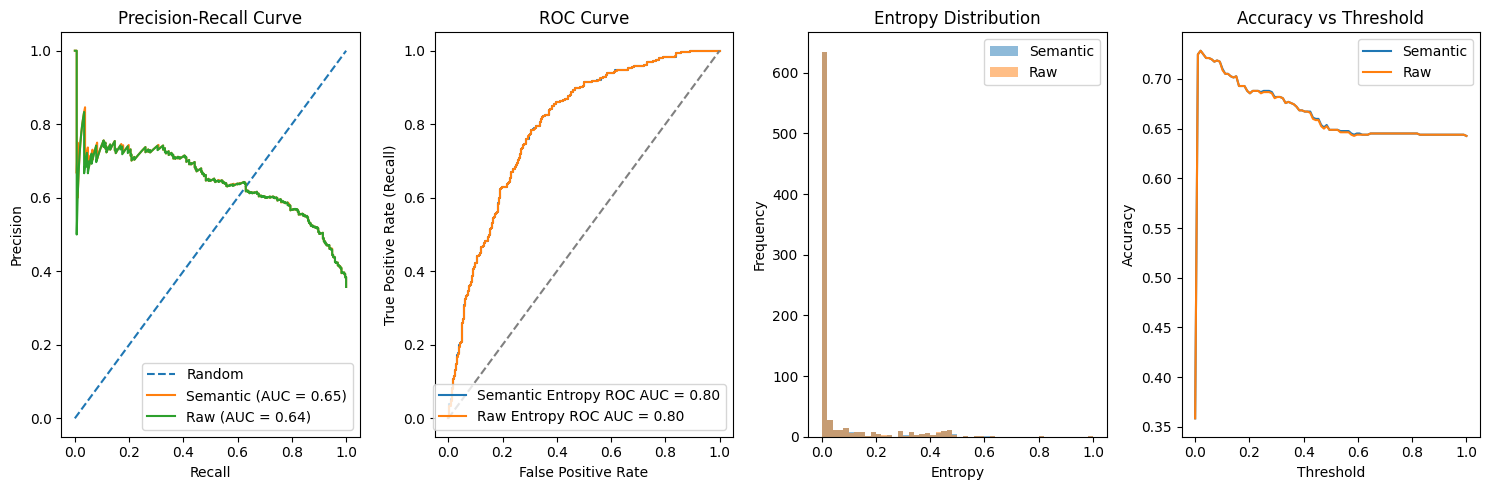

In [100]:
plot_metrics(scaled_mean_semantic_entropies, scaled_mean_entropies, did_hallucinate)

In [66]:
scaled_mean_entropies

array([1.03844300e-04, 3.47477084e-02, 7.59505895e-06, 5.77369684e-06,
       8.83051609e-03, 5.45526713e-05, 6.92048398e-05, 4.52750720e-01,
       1.25483304e-05, 4.26204402e-05, 2.86229959e-04, 1.13320705e-02,
       9.41998922e-06, 9.84858160e-04, 2.27011398e-03, 3.18868736e-01,
       1.00571015e-01, 3.08152182e-05, 1.49610167e-06, 3.38585211e-01,
       4.23062048e-05, 1.08771377e-05, 6.17155995e-06, 3.67176439e-01,
       5.62248993e-05, 6.10628029e-02, 9.56094250e-04, 4.14175169e-03,
       4.66998317e-06, 3.10414058e-03, 4.32453327e-01, 9.37369531e-03,
       1.44274063e-05, 5.48896235e-06, 1.20477247e-01, 2.49557685e-05,
       1.18382246e-03, 1.85758056e-03, 6.35513675e-01, 2.45404954e-03,
       3.92581846e-05, 2.64544054e-01, 2.97908693e-05, 5.52947530e-06,
       1.50047970e-02, 4.40355304e-03, 2.31062246e-06, 1.04842468e-05,
       1.64529359e-04, 3.90840608e-05, 0.00000000e+00, 7.86862869e-01,
       3.85724166e-05, 4.14028091e-06, 1.14572600e-02, 1.66961612e-02,
      